# Toy data wine classification

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parrt/fundamentals-of-deep-learning/blob/main/notebooks/4.binary-classifier-wine.ipynb)

In [2]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
import matplotlib.pyplot as plt
from matplotlib import colors 
import colour

%config InlineBackend.figure_format = 'retina'

import tsensor

## Load and normalize and display 2D variable space

In [3]:
d = load_wine()
sum(d.target==2)

48

In [4]:
df = pd.DataFrame(d.data, columns=d.feature_names)
df['class'] = d.target
df = df[df['class'].isin({0,1})]
df.head(3)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0


In [5]:
df = df[['proline','alcohol','class']]
df.head(3)

,proline,alcohol,class
0,1065.0,14.23,0
1,1050.0,13.20,0
2,1185.0,13.16,0


In [6]:
def show(df, normalize=False, file=None):
    if normalize:
        df = df.copy()
        df.proline = (df.proline-np.mean(df.proline))/np.std(df.proline)
        df.alcohol = (df.alcohol-np.mean(df.alcohol))/np.std(df.alcohol)
        
    fig, ax = plt.subplots(figsize=(4,3))
    df0 = df[df['class']==0]
    df1 = df[df['class']==1]
    ax.scatter(df0.proline, df0.alcohol, marker='x', s=45, color='#F46C43', alpha=1, label='class 0')
    ax.scatter(df1.proline, df1.alcohol, marker='o', s=45, color='#4574B4', alpha=.7, label='class 1')
    ax.set_xlabel("proline")
    ax.set_ylabel("alcohol")
    ax.set_title("Wine classification")
    plt.legend(loc='lower right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/parrt/Desktop/{file}.pdf")
    plt.show()

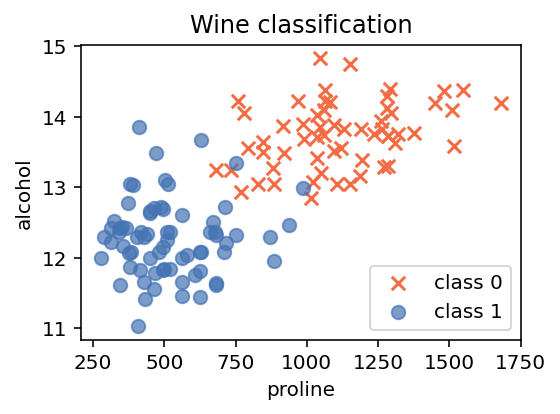

In [7]:
show(df, file="wine")

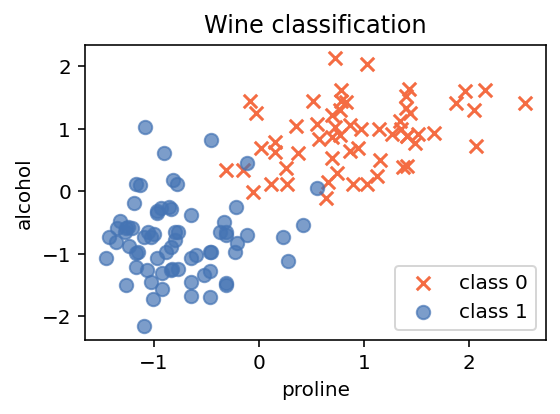

In [8]:
show(df, normalize=True, file="wine-norm")

## Train and show logistic regression decision boundary

In [9]:
def ctrain(model, X, y, learning_rate = .0001, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(nepochs+1):
        y_pred = model(X)
        loss = F.binary_cross_entropy(y_pred, y)
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:5d} cross entropy loss {loss:7.4f}")

        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"LAST        cross entropy loss {loss:7.4f}")
    return y_pred, loss

In [10]:
def dshow(X, y, model, boundary_tolerance=.03, file=None):
    grid = []
    for p in np.linspace(min(X[:,0]),max(X[:,0]),num=100):
        for a in np.linspace(min(X[:,1]),max(X[:,1]),num=100):
            grid.append([p,a])
    grid = torch.tensor(grid).float()
    decisions = model(grid).detach().numpy().reshape(-1)
    
    grid_boundary = grid[np.isclose(decisions,0.5,atol=boundary_tolerance),:]
    
    fig, ax = plt.subplots(figsize=(5,4))
    X0 = X[y==0]
    X1 = X[y==1]

    orange = colour.Color("#F46C43")
    blue = colour.Color("#4574B4")
    mycolors = np.array(list(c.hex for c in orange.range_to(blue, 100+1)))
    mycolors = mycolors[(decisions*100).astype(int)]
    cmap = plt.get_cmap('coolwarm')
    norm = colors.Normalize(np.min(decisions), np.max(decisions)) # cmap(norm(decisions))
    ax.scatter(grid[:,0], grid[:,1], s=.2, c=mycolors, alpha=.3)

    ax.scatter(grid_boundary[:,0], grid_boundary[:,1], s=1, c='k', alpha=1)

    ax.scatter(X0[:,0], X0[:,1], marker='x', s=45, lw=.9, color='#F46C43', alpha=1, label='class 0')
    ax.scatter(X1[:,0], X1[:,1], marker='o', s=45, lw=.9, color='#4574B4', alpha=.75, label='class 1')    

    ax.set_xlabel("proline")
    ax.set_ylabel("alcohol")
    ax.set_title("Wine classification")
    plt.legend(loc='lower right')
    plt.tight_layout()

    if file:
        plt.savefig(f"/Users/parrt/Desktop/{file}.pdf")
    
    plt.show()

Epoch     0 cross entropy loss  0.4308
Epoch  1500 cross entropy loss  0.1506
Epoch  3000 cross entropy loss  0.1049
Epoch  4500 cross entropy loss  0.0879
Epoch  6000 cross entropy loss  0.0804
Epoch  7500 cross entropy loss  0.0771
Epoch  9000 cross entropy loss  0.0760
Epoch 10500 cross entropy loss  0.0759
Epoch 12000 cross entropy loss  0.0758
Epoch 13500 cross entropy loss  0.0758
Epoch 15000 cross entropy loss  0.0758
LAST        cross entropy loss  0.0758


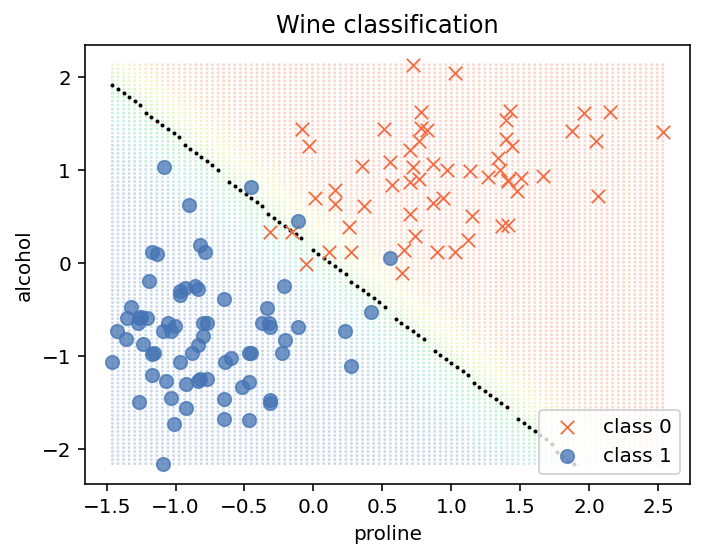

In [11]:
model = nn.Sequential(
    nn.Linear(2, 1), # 2 input vars: proline, alcohol
    nn.Sigmoid(),
)
X = df[['proline','alcohol']].values
y = df['class'].values
X = (X-np.mean(X,axis=0))/np.std(X,axis=0)
X_ = torch.tensor(X).float()
y_ = torch.tensor(y).reshape(-1,1).float()
y_pred, loss = ctrain(model, X=X_, y=y_, learning_rate = .001, nepochs=15_000)

dshow(X, y, model, boundary_tolerance=.02, file="lin1S")

## Train input layer with 3 neurons + output layer

Epoch     0 cross entropy loss  0.7167
Epoch  1500 cross entropy loss  0.2334
Epoch  3000 cross entropy loss  0.1223
Epoch  4500 cross entropy loss  0.0958
Epoch  6000 cross entropy loss  0.0847
Epoch  7500 cross entropy loss  0.0718
Epoch  9000 cross entropy loss  0.0594
Epoch 10500 cross entropy loss  0.0519
Epoch 12000 cross entropy loss  0.0466
Epoch 13500 cross entropy loss  0.0434
Epoch 15000 cross entropy loss  0.0413
LAST        cross entropy loss  0.0413


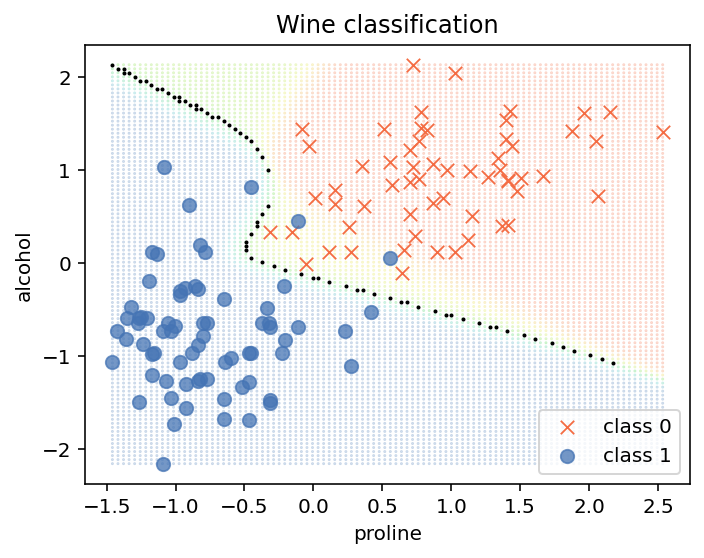

In [18]:
model = nn.Sequential(
    nn.Linear(2, 3),
    nn.Sigmoid(),
    nn.Linear(3, 1),
    nn.Sigmoid()
)
X = df[['proline','alcohol']].values
y = df['class'].values
X = (X-np.mean(X,axis=0))/np.std(X,axis=0)
X_ = torch.tensor(X).float()
y_ = torch.tensor(y).reshape(-1,1).float()
y_pred, loss = ctrain(model, X=X_, y=y_, learning_rate = .001, nepochs=15_000)

dshow(X, y, model, file="lin3Slin1S")

## Train input layer with 10 neurons + output layer

Epoch     0 cross entropy loss  0.7710
Epoch  1500 cross entropy loss  0.0809
Epoch  3000 cross entropy loss  0.0762
Epoch  4500 cross entropy loss  0.0635
Epoch  6000 cross entropy loss  0.0523
Epoch  7500 cross entropy loss  0.0433
Epoch  9000 cross entropy loss  0.0299
Epoch 10500 cross entropy loss  0.0120
Epoch 12000 cross entropy loss  0.0044
Epoch 13500 cross entropy loss  0.0017
Epoch 15000 cross entropy loss  0.0006
LAST        cross entropy loss  0.0006


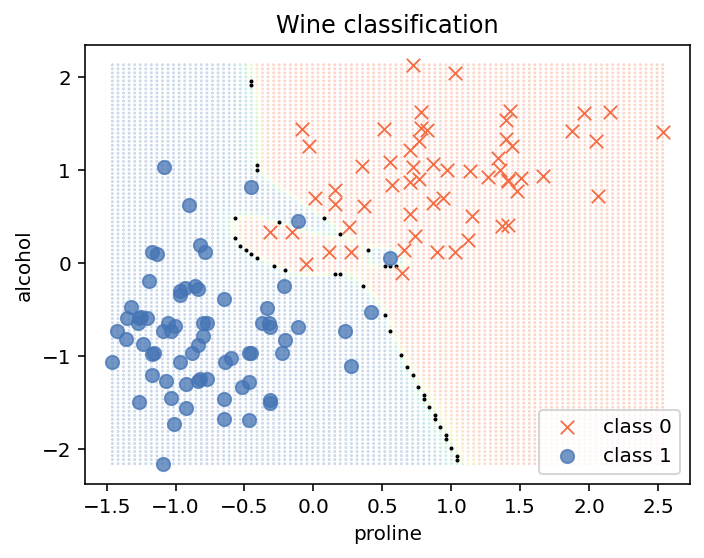

In [20]:
model = nn.Sequential(
    nn.Linear(2, 10), # 2 input vars: proline, alcohol
    nn.Sigmoid(),
    nn.Linear(10, 1),
    nn.Sigmoid()
)
X = df[['proline','alcohol']].values
y = df['class'].values
X = (X-np.mean(X,axis=0))/np.std(X,axis=0)
X_ = torch.tensor(X).float()
y_ = torch.tensor(y).reshape(-1,1).float()
y_pred, loss = ctrain(model, X=X_, y=y_, learning_rate = .002, nepochs=15_000)

dshow(X, y, model, boundary_tolerance=.07, file="lin10Slin")

## Train one-hidden layer with 10 neurons

Epoch     0 cross entropy loss  0.7160
Epoch  1000 cross entropy loss  0.0499
Epoch  2000 cross entropy loss  0.0392
Epoch  3000 cross entropy loss  0.0089
Epoch  4000 cross entropy loss  0.0010
Epoch  5000 cross entropy loss  0.0003
Epoch  6000 cross entropy loss  0.0001
Epoch  7000 cross entropy loss  0.0001
Epoch  8000 cross entropy loss  0.0000
Epoch  9000 cross entropy loss  0.0000
Epoch 10000 cross entropy loss  0.0000
LAST        cross entropy loss  0.0000


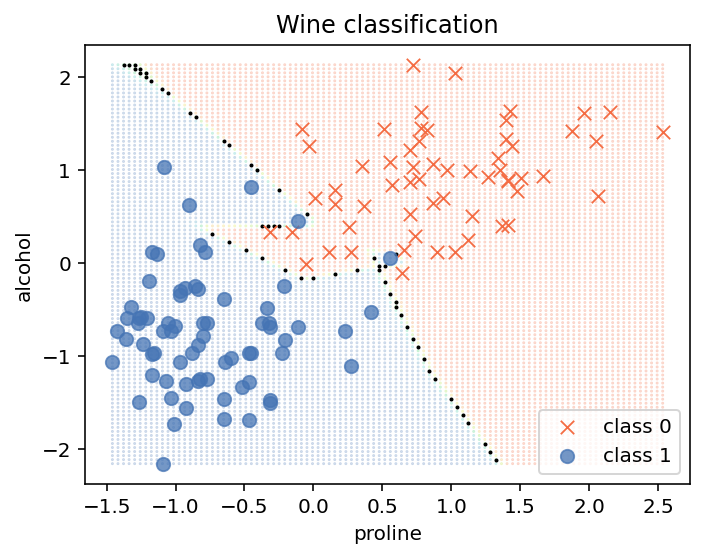

In [23]:
model = nn.Sequential(
    nn.Linear(2, 10), # 2 input vars: proline, alcohol
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
    nn.Sigmoid()
)
X = df[['proline','alcohol']].values
y = df['class'].values
X = (X-np.mean(X,axis=0))/np.std(X,axis=0)
X_ = torch.tensor(X).float()
y_ = torch.tensor(y).reshape(-1,1).float()
y_pred, loss = ctrain(model, X=X_, y=y_, learning_rate = .002, nepochs=10_000)

dshow(X, y, model, boundary_tolerance=.1, file="lin2Rlin10Rlin")